In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../../xtrack/examples/fcc_ee_solenoid/fccee_z_with_sol.json')

Loading line from dict:   0%|          | 0/79096 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
tw_sol_off = line.twiss4d()

Found suitable prebuilt kernel `default_xcoll`.
Found suitable prebuilt kernel `default_xcoll_frozen_energy`.


## Switch on tilted solenoid

In [5]:
line.vars['on_sol_ip.1'] = 1
tw_sol_on = line.twiss(method='4d')

**Beta beating**

Text(0.5, 0, 's [m]')

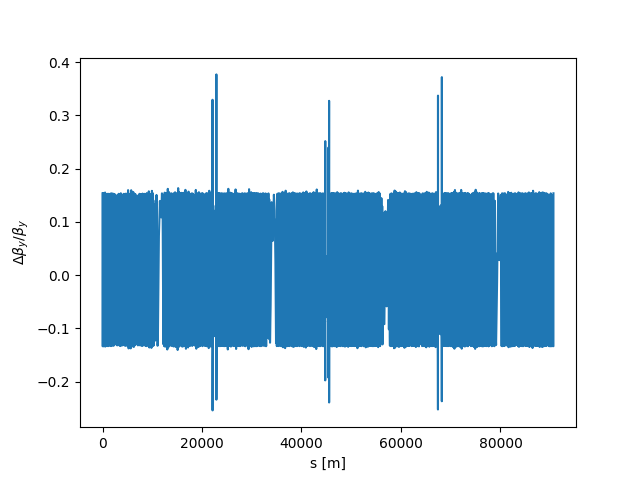

In [6]:
plt.figure()
plt.plot(tw_sol_off.s, tw_sol_on.bety/tw_sol_off.bety - 1)
plt.ylabel(r'$\Delta \beta_y / \beta_y$')
plt.xlabel('s [m]')

In [7]:
tw_sol_on.c_minus

0.0003202514071446824

Text(0, 0.5, 'x [mm]')

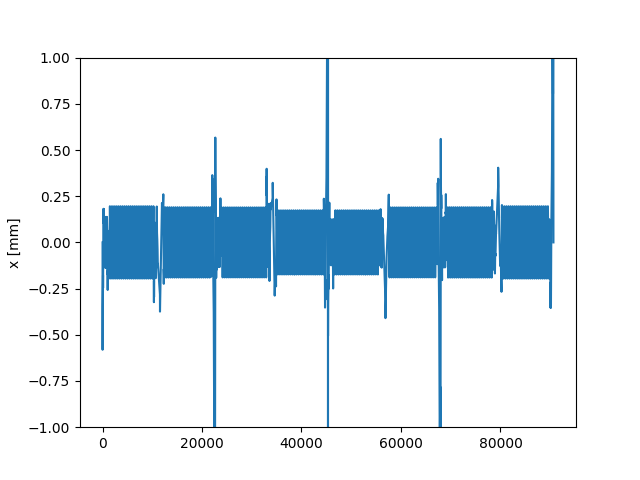

In [8]:
plt.figure()
plt.plot(tw_sol_off.s, tw_sol_on.x*1e3)
plt.ylim(-1, 1)
plt.ylabel('x [mm]')

## Correct locally orbit, coupling and optics

#### Correction strategy for the right side

In [9]:
opt_r = line.match(
    solve=False,
    method='4d', n_steps_max=30,
    start='ip.1', end='pqc2re.1',
    init=tw_sol_off, init_at=xt.END,
    vary=[
        xt.VaryList(['acb1h.r1', 'acb2h.r1','acb1v.r1', 'acb2v.r1'], step=1e-8, tag='corr_r'),            # dipole corr
        xt.VaryList(['ks1.r1', 'ks2.r1', 'ks3.r1', 'ks0.r1'], step=1e-7, tag='skew_r'),                   # skeq quad
        xt.VaryList(['corr_k1.r1', 'corr_k2.r1', 'corr_k3.r1', 'corr_k0.r1'], step=1e-6, tag='normal_r'), # norm quad
    ],
    targets=[
        xt.TargetSet(['x', 'y'], value=tw_sol_off, tol=1e-7, at='ip.1', tag='orbit'),
        xt.TargetSet(['px', 'py'], value=tw_sol_off, tol=1e-10, at='ip.1', tag='orbit'),
        xt.TargetRmatrix(r13=0, r14=0, r23=0, r24=0, # Y-X block
                         r31=0, r32=0, r41=0, r42=0, # X-Y block,
                         start='ip.1', end='pqc2re.1', tol=1e-6, tag='coupl'),
        xt.Target('mux', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('muy', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('betx', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=1, tol=1e-5),
        xt.Target('bety', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=10, tol=1e-6),
        xt.Target('alfx', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),
        xt.Target('alfy', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),

    ]
)

Found suitable prebuilt kernel `default_xcoll_backtrack_frozen_energy`.


In [10]:
opt_r.target_status()

Target status:                          
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit    False -2.29394e-06 -2.29394e-06 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -2.82132e-10 -2.82132e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit    False   1.6033e-06     0.015001    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit    False  1.84498e-06  1.84498e-06            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl    False  0.000344796  0.000344796            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl    False   0.00154466   0.00154466            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl    False -2.21248e-05 -2.21248e-05            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl    False -5.52266e-05 -5.52266e-05            0 r24(ip.1, pqc2re.1, val=0, tol=1

#### Match orbit alone

In [11]:
# Enable only orbit targets
opt_r.disable_all_targets();
opt_r.enable_targets(tag='orbit'); 
opt_r.target_status()

Target status:                          
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit    False -2.29394e-06 -2.29394e-06 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -2.82132e-10 -2.82132e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit    False   1.6033e-06     0.015001    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit    False  1.84498e-06  1.84498e-06            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 OFF   coupl    False            0  0.000344796            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 OFF   coupl    False            0   0.00154466            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 OFF   coupl    False            0 -2.21248e-05            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 OFF   coupl    False            0 -5.52266e-05            0 r24(ip.1, pqc2re.1, val=0, tol=1

In [12]:
# Enable dipole corrector knobs
opt_r.enable_vary(tag='corr_r')
opt_r.vary_status()

Vary status:                 
id state tag      name       lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    corr_r   acb1h.r1          None           0        None             0 1e-08      1
 1 ON    corr_r   acb2h.r1          None           0        None             0 1e-08      1
 2 ON    corr_r   acb1v.r1          None           0        None             0 1e-08      1
 3 ON    corr_r   acb2v.r1          None           0        None             0 1e-08      1
 4 ON    skew_r   ks1.r1            None           0        None             0 1e-07      1
 5 ON    skew_r   ks2.r1            None           0        None             0 1e-07      1
 6 ON    skew_r   ks3.r1            None           0        None             0 1e-07      1
 7 ON    skew_r   ks0.r1            None           0        None             0 1e-07      1
 8 ON    normal_r corr_k1.r1        None           0        None             0 1e-06      1
 9 ON    normal_r corr_k2.r1        None          

In [13]:
# Solve
opt_r.solve()
opt_r.target_status()

Matching: model call n. 16               

Target status:                           
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True -5.47745e-14 -5.48187e-14 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -6.35875e-14 -6.35875e-14            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit     True -4.74065e-14    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True  6.81504e-17  6.81504e-17            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 OFF   coupl    False            0  0.000344976            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 OFF   coupl    False            0   0.00154432            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 OFF   coupl    False            0 -2.21285e-05            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 OFF   coupl    False            0 -5.52142e-05  

#### Match coupling alone

In [14]:
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='coupl'); opt_r.enable_vary(tag='skew_r');
opt_r.solve()
opt_r.target_status()

Matching: model call n. 148               

Target status:                            
id state tag    tol_met      residue  current_val   target_val description                                 
 0 OFF   orbit     True            0  3.14382e-09 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 OFF   orbit     True            0  8.42433e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 OFF   orbit    False            0    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 OFF   orbit     True            0  9.36278e-12            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True  1.71594e-08  1.71594e-08            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True   1.7791e-09   1.7791e-09            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl     True  2.42583e-12  2.42583e-12            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True -1.98608e-10 -1.98608e-10

#### Match optics alone ($\mu_{x, y}$,$\beta_{x, y}$, $\alpha_{x, y}$)

In [15]:
# phase, beta and alpha alone
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_vary(tag='normal_r')
opt_r.enable_targets(tag='mu_ip'); opt_r.solve()
opt_r.enable_targets(tag='bet_ip'); opt_r.solve()
opt_r.enable_targets(tag='alf_ip'); opt_r.solve()

Matching: model call n. 161               

Matching: model call n. 173               

Matching: model call n. 174               



In [16]:
opt_r.enable_all_targets()
opt_r.target_status()

Target status:                            
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True  3.25701e-09  3.25701e-09 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True  6.55591e-10  6.55591e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit    False -4.84803e-10    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True  6.28796e-11  6.28796e-11            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True -6.76784e-08 -6.76784e-08            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True -8.86499e-08 -8.86499e-08            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl    False  2.65937e-08  2.65937e-08            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True  6.23377e-09  6.23377e-09            0 r24(ip.1, pqc2re.1, val=0, tol

### Another iteration to refine the solution

In [17]:
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='orbit'); opt_r.enable_vary(tag='corr_r'); opt_r.solve()

opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='coupl'); opt_r.enable_vary(tag='skew_r'); opt_r.solve()

opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_vary(tag='normal_r')
opt_r.enable_targets(tag='mu_ip'); opt_r.solve()
opt_r.enable_targets(tag='bet_ip'); opt_r.solve()
opt_r.enable_targets(tag='alf_ip'); opt_r.solve()


Matching: model call n. 181               

Matching: model call n. 187               

Matching: model call n. 188               

Matching: model call n. 189               

Matching: model call n. 190               



In [18]:
# Inspect the result
opt_r.enable_all_targets()
opt_r.target_status()

Target status:                            
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True  -4.0295e-13 -4.02995e-13 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -1.02004e-13 -1.02004e-13            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit     True   4.4369e-14    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True -9.22815e-15 -9.22815e-15            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True  8.54491e-08  8.54491e-08            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True  4.66696e-10  4.66696e-10            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl     True -4.19036e-09 -4.19036e-09            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True  1.16271e-10  1.16271e-10            0 r24(ip.1, pqc2re.1, val=0, tol

In [19]:
# Inspect the knobs
opt_r.vary_status()

Vary status:                 
id state tag      name       lower_limit  current_val upper_limit val_at_iter_0  step weight
 0 OFF   corr_r   acb1h.r1          None  -3.9892e-06        None             0 1e-08      1
 1 OFF   corr_r   acb2h.r1          None  1.76495e-06        None             0 1e-08      1
 2 OFF   corr_r   acb1v.r1          None  4.37252e-06        None             0 1e-08      1
 3 OFF   corr_r   acb2v.r1          None -3.99763e-06        None             0 1e-08      1
 4 OFF   skew_r   ks1.r1            None  0.000615817        None             0 1e-07      1
 5 OFF   skew_r   ks2.r1            None -0.000328413        None             0 1e-07      1
 6 OFF   skew_r   ks3.r1            None  -0.00077012        None             0 1e-07      1
 7 OFF   skew_r   ks0.r1            None  0.000717664        None             0 1e-07      1
 8 ON    normal_r corr_k1.r1        None -6.91197e-05        None             0 1e-06      1
 9 ON    normal_r corr_k2.r1        None

In [20]:
opt_l = line.match(
    solve=False, method='4d', n_steps_max=30,
    start='pqc2le.4', end='ip.1', init=tw_sol_off, init_at=xt.START,
    vary=[xt.VaryList(['acb1h.l1', 'acb2h.l1','acb1v.l1', 'acb2v.l1'], step=1e-8, tag='corr_l'),
          xt.VaryList(['ks1.l1', 'ks2.l1', 'ks3.l1', 'ks0.l1'], step=1e-7, tag='skew_l'),
          xt.VaryList(['corr_k1.l1', 'corr_k2.l1', 'corr_k3.l1', 'corr_k0.l1'], step=1e-6, tag='normal_l')],
    targets=[
        xt.TargetSet(['x', 'y'], value=tw_sol_off, tol=1e-7, at='ip.1', tag='orbit'),
        xt.TargetSet(['px', 'py'], value=tw_sol_off, tol=1e-10, at='ip.1', tag='orbit'),
        xt.TargetRmatrix(r13=0, r14=0, r23=0, r24=0, r31=0, r32=0, r41=0, r42=0,
                         start='pqc2le.4', end='ip.1', tol=1e-6, tag='coupl'),
        xt.Target('mux', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('muy', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('betx', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=1, tol=1e-5),
        xt.Target('bety', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=10, tol=1e-6),
        xt.Target('alfx', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),
        xt.Target('alfy', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),])

for iter in range(2):
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_targets(tag='orbit'); opt_l.enable_vary(tag='corr_l'); opt_l.solve()
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_targets(tag='coupl'); opt_l.enable_vary(tag='skew_l'); opt_l.solve()
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_vary(tag='normal_l')
    opt_l.enable_targets(tag='mu_ip'); opt_l.solve()
    opt_l.enable_targets(tag='bet_ip'); opt_l.solve()
    opt_l.enable_targets(tag='alf_ip'); opt_l.solve()

Matching: model call n. 6               

Matching: model call n. 24               

Matching: model call n. 36               

Matching: model call n. 48               

Matching: model call n. 49               

Matching: model call n. 55               

Matching: model call n. 61               

Matching: model call n. 62               

Matching: model call n. 63               

Matching: model call n. 64               



In [21]:
opt_l.enable_all_targets(); opt_l.enable_all_vary()
opt_l.target_status()
opt_l.vary_status()

Target status:                           
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True  3.87607e-13  3.87563e-13 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -1.02849e-13 -1.02849e-13            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit     True  5.01699e-14    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True  3.96288e-15  3.96288e-15            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True  -5.2484e-11  -5.2484e-11            0 r13(pqc2le.4, ip.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True -3.76635e-08 -3.76635e-08            0 r14(pqc2le.4, ip.1, val=0, tol=9.9999999 ...
 6 ON    coupl     True  1.09118e-10  1.09118e-10            0 r23(pqc2le.4, ip.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True -3.51218e-08 -3.51218e-08            0 r24(pqc2le.4, ip.1, val=0, tol=

## Plot results

In [22]:
tw_sol_on_corrected = line.twiss(method='4d')

Text(0.5, 0, 's [m]')

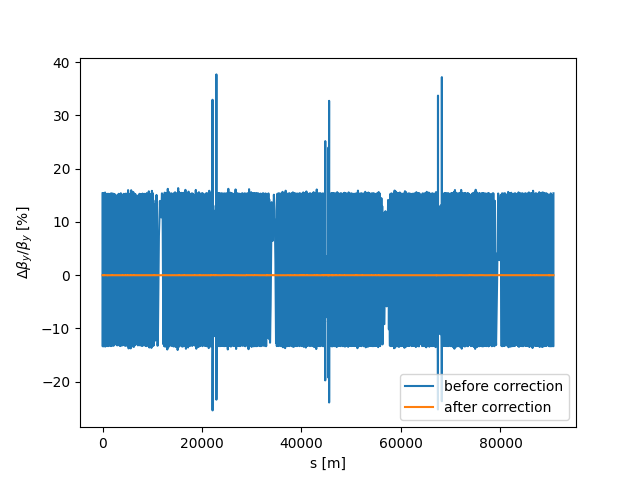

In [23]:
plt.figure()
plt.plot(tw_sol_on.s, 100 * (tw_sol_on.bety/tw_sol_off.bety - 1), label='before correction')
plt.plot(tw_sol_on.s, 100 * (tw_sol_on_corrected.bety/tw_sol_off.bety - 1), label='after correction')
plt.ylabel(r'$\Delta \beta_y / \beta_y$ [%]')
plt.legend()
plt.xlabel('s [m]')

|C-| before:  0.0003202514071446824
|C-| after :  4.1967677796501405e-08


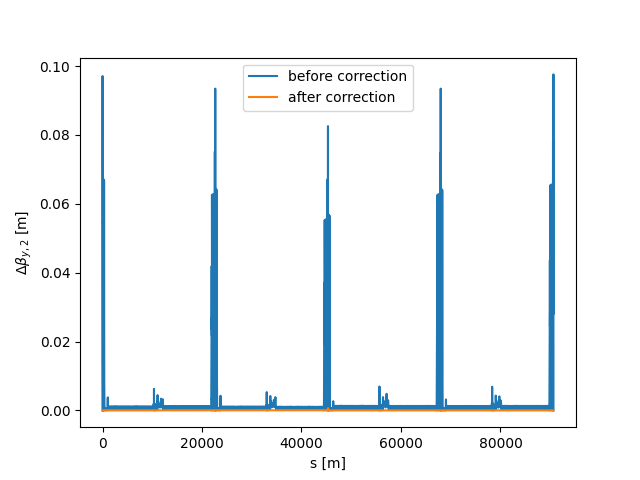

In [24]:
# Coupling
plt.figure()
plt.plot(tw_sol_on.s, tw_sol_on.bety1, label='before correction')
plt.plot(tw_sol_on.s, tw_sol_on_corrected.bety1, label='after correction')
plt.ylabel(r'$\Delta \beta_{y,2}$ [m]')
plt.legend()
plt.xlabel('s [m]')

print('|C-| before: ', tw_sol_on.c_minus)
print('|C-| after : ', tw_sol_on_corrected.c_minus)

Text(0.5, 0, 's [m]')

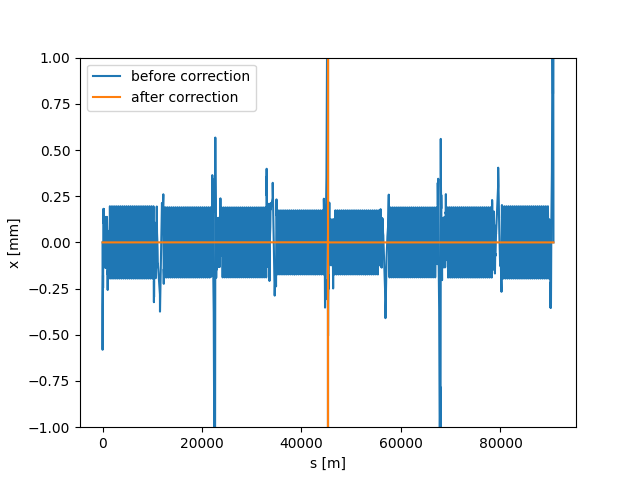

In [25]:
# Orbit
plt.figure()
plt.plot(tw_sol_on.s, 1000 * tw_sol_on.x, label='before correction')
plt.plot(tw_sol_on.s, 1000 * tw_sol_on_corrected.x, label='after correction')
plt.ylabel(r'x [mm]')
plt.ylim(-1,1)
plt.legend()
plt.xlabel('s [m]')